# Pairwise disorder comparison between effectors and reference proteomes - Disopred

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import mannwhitneyu

import sys
sys.path.append('../src/')

import aepathdisorder as aepd

%matplotlib inline

In [2]:
# Load maps
bug_map = aepd.load_map('../data/maps/reference_taxa.json')
CR_map = aepd.load_map('../data/maps/CR_taxa.json')
EHEC_map = aepd.load_map('../data/maps/EHEC_taxa.json')
EPEC_map = aepd.load_map('../data/maps/EPEC_taxa.json')

# Load Disopred results
bug_disopred = glob.glob('../data/disopred_agg-clas/proteomes/*/*.table')
EHEC_disopred = glob.glob('../data/disopred_agg-clas/EHEC_effectors/*.table')
EPEC_disopred = glob.glob('../data/disopred_agg-clas/EPEC_effectors/*.table')
CR_disopred = glob.glob('../data/disopred_agg-clas/CR_effectors/*.table')
#human_cat_short = glob.glob('../data/iupredagg-clas/human_proteome/*short*.table')



In [3]:
#human_df = concatenate_results(human_disopred)
bug_df = aepd.concatenate_results(bug_disopred)
EHEC_df = aepd.concatenate_results(EHEC_disopred)
EPEC_df = aepd.concatenate_results(EPEC_disopred)
CR_df = aepd.concatenate_results(CR_disopred)

effector_types = ['EHEC', 'EPEC', 'CR']
effector_dfs = [EHEC_df, EPEC_df, CR_df]
effector_maps = [EHEC_map, EPEC_map, CR_map]

for df, mapdict in zip(effector_dfs, effector_maps):
    #df.drop(['dataset'], axis=1,  inplace=True)
    df['dataset'] = df['protein_ac'].map(mapdict)
    df['collection_type'] = 'Effector'

for df, effector_type in zip(effector_dfs, effector_types):
    df['effector_type'] = effector_type
# Make bug taxa strings (stored as int)
bug_df['dataset'] = bug_df['dataset'].astype(str)
# Define references as such
bug_df['collection_type'] = 'Reference'

merged_effector_df = pd.concat(effector_dfs)


In [4]:
bug_efftype_map = {}
for k, v in bug_map.items():
    bug_efftype_map[k] = v['type']

bug_efftype_map

{'244319': 'EHEC',
 '362663': 'UPEC',
 '574521': 'EPEC',
 '585395': 'EHEC',
 '585396': 'EHEC',
 '637910': 'CR',
 '83334': 'EHEC'}

In [5]:
effector_taxa  = set(merged_effector_df['dataset'])
reference_taxa = set(bug_df['dataset'])

paired_taxa = effector_taxa & reference_taxa

paired_effectors = merged_effector_df[merged_effector_df['dataset'].isin(paired_taxa)]
paired_bugs = bug_df[bug_df['dataset'].isin(paired_taxa)]

In [6]:
paired_bugs['effector_type'] = paired_bugs['dataset'].map(bug_efftype_map) 

In [7]:
final_df = pd.concat([paired_effectors, paired_bugs], ignore_index=True)
final_df.reset_index(inplace=True)
# Drop effectors from Reference collections
final_df = final_df.sort_values(by='collection_type').drop_duplicates(subset='protein_ac')

In [12]:
len(final_df)

14451

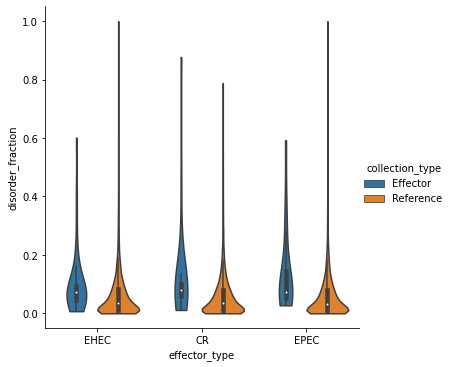

In [9]:
sns.catplot(
    x='effector_type',
    y='disorder_fraction',
    hue='collection_type',
    data=final_df,
    kind='violin',
    cut=0)

plt.savefig('../figures/pairwise_disopred.png',
            dpi=300)

In [10]:
mwu_stat_df = aepd.calc_mannwithney(final_df)
mwu_stat_df.to_csv('../data/disopred_agg-clas/mannwithney-disopred.tsv', sep='\t', index_label='Effector collection')

mwu_stat_df


,Reference taxon,p-value
CR,637910,0.000039
EHEC,83334,0.000071
EPEC,574521,0.000036


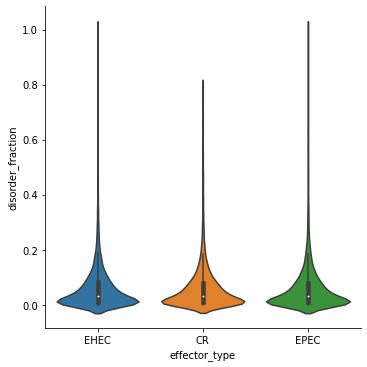

In [11]:
sns.catplot(
    x='effector_type',
    y='disorder_fraction',
    data=final_df[final_df['collection_type']=='Reference'],
    kind='violin')